# Title: What is the Myers–Briggs Type Indicator (MBTI) Associated with the Type of Music?

Link to the dataset: https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists

In [5]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



### Introduction:

Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
* What is MBTI?
* Songs and personality

Clearly state the question you will try to answer with your project
* What is the Myers–Briggs Type Indicator (MBTI) Associated with the Given Song?
* Classify the MBTI associated with the given song

Identify and describe the dataset that will be used to answer the question
* see the dataset context

### Preliminary exploratory data analysis:

* Clean and wrangle your data into a tidy format (already tidy)

In [8]:
spotify_mbti <- read_csv("combine_mbti_df.csv") |>
    mutate(mbti = as_factor(mbti))
spotify_mbti

Rows: 4081 Columns: 46
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): mbti, function_pair
dbl (44): danceability_mean, danceability_stdev, energy_mean, energy_stdev, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mbti,function_pair,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,⋯,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,NF,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,⋯,2,2,1,4,0,0,0,0,0,0
INFP,NF,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,⋯,1,2,1,4,1,1,1,1,0,0
INFP,NF,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,⋯,0,1,1,3,1,0,0,1,2,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,SJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,⋯,1,1,2,0,1,0,0,0,0,1
ESTJ,SJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,⋯,2,0,3,1,0,1,2,2,1,3
ESTJ,SJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,⋯,2,0,4,1,2,0,3,1,2,2


In [16]:
set.seed(1)

spotify_split <- initial_split(spotify_mbti, prop = 0.75, strata = mbti)  
spotify_mbti_train <- training(spotify_split)   
spotify_mbti_test <- testing(spotify_split)

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data.

In [15]:
observation_count <- spotify_mbti_traing |>
    group_by(mbti) |>
    summarize(count = n())
observation_count

ERROR: Error in group_by(spotify_mbti_traing, mbti): object 'spotify_mbti_traing' not found


Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

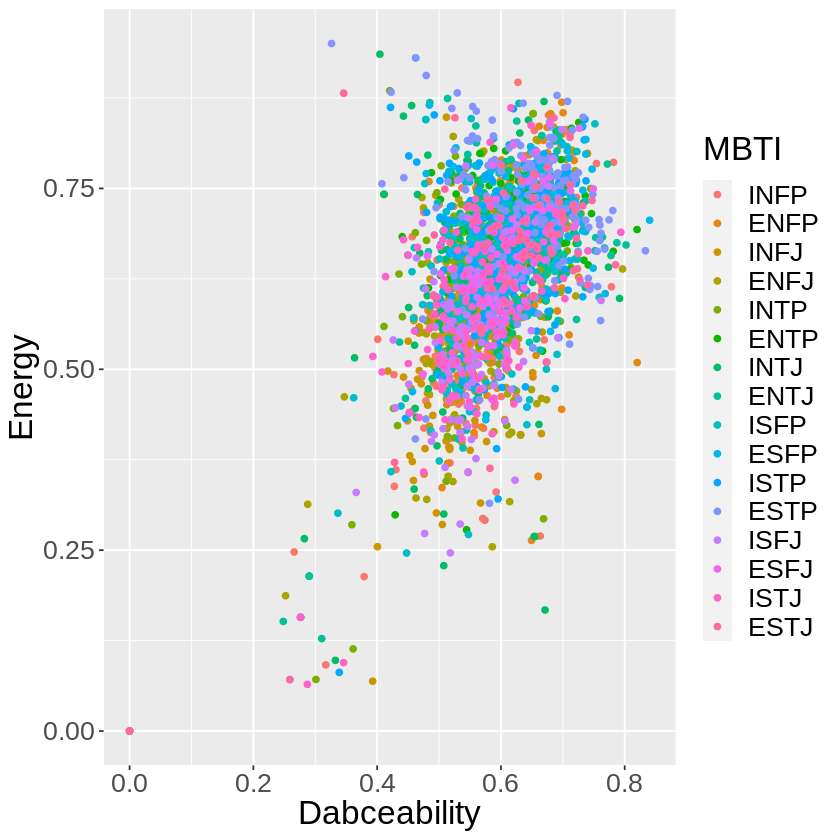

In [17]:
visualization <- spotify_mbti_train |>  
    ggplot(aes(x = danceability_mean, 
               y = energy_mean, 
               colour = mbti)) +
        labs(x = "Dabceability",
             y = "Energy",
            colour = 'MBTI') +
        geom_point() +
        theme(text = element_text(size = 20))
visualization

### Methods: (Megan)
Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
* The keys are in separated column. To decrease the number of predictable variables, we need to put all the majors into one column and all the minors into another.
* Remove function_pair

Describe at least one way that you will visualize the results
* visualize confusion_matrix (correctly identified vs. incorrectly identified; bar chart)

### Expected outcomes and significance:
##### What do you expect to find?

It is difficult to predict with confidence what we will find by analyzing music types and MBTI because music preference is complex and highly unique. However, we may be able to find correlations between certain MBTI types and specific factors in music, such as energy levels, danceability, key, loudness, etc. Using these trends we hope to predict an individual’s MBTI type based on variables of the music they enjoy.

##### What impact could such findings have?

Although the MBTI system is a controversial topic in the psychology community due to its inability to fully represent the intricacies of human personality, our project may prove to be useful in developing a general understanding of the relationship between music and personality. This knowledge may be purposeful in many areas, including but not limited to:

Personal development: Individuals may utilize a better understanding of the relationship between their personality and music types to make well-informed decisions on their music of choice, or explore new types of music that may better align with their personality type.

Advertisement: A better understanding of the relationship between personality and music type may allow companies to better curate targeted marketing strategies, such as personalized advertisements for musical merchandise or specially-made playlists.

Music recommendation algorithms: Streaming platforms may be able to follow personality and music trends to suggest music more suitable to the listener’s personality type.

##### What future questions could this lead to?

There are several questions that our project could lead to, such as:

Can musical preferences be used to suggest personality traits beyond MBTI types?

Is there a difference in musical preference depending on mood/situation?

How do environmental factors influence the relationship between music preferences and personality types?